Machine L

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
#warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
#warnings.simplefilter(action='ignore', category=FutureWarning)

def loadFile(googleTrue, file = None ):
    if googleTrue == True:
        from google.colab import drive
        drive.mount('/content/drive')
        x = pd.read_csv("drive/MyDrive/train_data.csv")
    else:
        x = pd.read_csv(file)
    return x

train_data = loadFile(False, "data/train_data.csv")
test_data = loadFile(False, "data/test_data.csv")
supp_data = loadFile(False, "data/supplimental_data.csv")

In [ ]:
grouped = GS0.groupby("UserID")
tscv = TimeSeriesSplit(n_splits = 3)
tree = DecisionTreeRegressor(criterion = "squared_error", max_depth = 5)

model = {}
predsList = []
testList = []

for UserID, data in grouped:
    data = data.reset_index()
    if len(data) < 4:
        continue
    X, y = data[FEATURES], data[TARGET]
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        X_train, y_train, X_test, y_test = X.iloc[train_idx], y.iloc[train_idx], X.iloc[val_idx], y.iloc[val_idx]
        
        tree = tree.fit(X_train, y_train)
        preds = tree.predict(X_test)
        tests = y_test
        mae = mean_absolute_error(tests, preds)
    model[UserID] = fold, tree, mae

    predsList.extend(tree.predict(X_test))
    testList.extend(y_test["ResponseValue"])
    
mean_absolute_error(testList, predsList)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV


grouped = Gs0[:2000].groupby("UserID")
tscv = TimeSeriesSplit(n_splits = 3)

score = []
model = {}

allTrue = []
allPredict = []

for UserID, data in grouped:
    score = []
    data = data.reset_index()
    
    dataSize = len(data)
    testSize = int(dataSize * 0.7)
    
    if testSize < 5:
        continue
    
    train, test = data.iloc[:testSize], data.iloc[testSize:]
    X_test, y_test = test[FEATURES], test[TARGET]
    X, y = train[FEATURES], train[TARGET]
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(train)):
        X_train, y_train, X_val, y_val = X.iloc[train_idx], np.ravel(y.iloc[train_idx]), X.iloc[val_idx], np.ravel(y.iloc[val_idx])
        rf = RandomForestRegressor(criterion = "squared_error", max_depth = 5, max_leaf_nodes = 20, n_estimators = 10)
        rf.fit(X_train, y_train)
        validationTrue = y_val
        validationPredict = rf.predict(X_val)
        
        valMAE = mean_absolute_error(validationTrue, validationPredict)
        score.extend([fold, valMAE, best])
    
    testTrue = y_test["ResponseValue"]
    testPredict = rf.predict(X_test)
    
    testMAE = mean_absolute_error(testTrue, testPredict)
    model[UserID] = rf, score, testMAE, dataSize
    
    allTrue.extend(testTrue)
    allPredict.extend(testPredict)
    
    
OVERALL = mean_absolute_error(allTrue, allPredict)
OVERALL

In [3]:
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit

# Functions
Time converted to numerical because most models do not support datetime. Missing values in levelprogression were filled with 0 because most NA's also had sessionlength 0. sumDf creates summary statistics for each user which are used to train the kmeans clustering
algorithm. In previous iterations, currentgamemode was converted to a binary with career being 1 and all other values 0, due to class imbalance that was the best. QuestionTiming was also converted to binary but these did not help much either. 

In [5]:
def fillLPA(df):
    df.loc[:, "LevelProgressionAmount"] = df.loc[:, "LevelProgressionAmount"].apply(lambda x: 0 if pd.isna(x) else x)
    return df

In [6]:
def numericalTime(df):
    TimeUtcDate = pd.to_datetime(df.loc[:, "TimeUtc"])
    TimeUtcNumeric = pd.to_numeric(TimeUtcDate)
    df.loc[:, "TimeUtc"] = TimeUtcNumeric
    return df

In [7]:
def binaryQuestion(df):
    df.loc[:, "QuestionType"] = df.loc[:, "QuestionType"].astype(str)
    df.loc[:, "QuestionType"] = df.loc[:, "QuestionType"].apply(lambda x: 1 if x.strip() == "Wellbeing" else 0)
    return df

In [8]:
def scaleVariables(df):
    scaler = StandardScaler()
    grouped = df.groupby("UserID")
    result = pd.DataFrame()
    for UserID, data in grouped:
        before = pd.DataFrame(data[FEATURES])
        after = scaler.fit_transform(X = before)
        afterDf = pd.DataFrame(after, index=data.index, columns = FEATURES)
        result = pd.concat([result, afterDf])
    result = result.sort_index()
    try:
        df1 = df[["TimeUtc", "UserID", "QuestionType", "ResponseValue"]]
    except:
        df1 = df[["TimeUtc", "UserID", "QuestionType"]]
    df2 = pd.concat([df1, result], axis = 1)
    return df2

In [9]:
def indexTime(df):
    df.index = pd.to_datetime(df["TimeUtc"], format = "%Y-%m-%d %H:%M:%S")
    df = df.drop(columns = ["TimeUtc"])
    return df

# Grouped Model
Grouping the users is a better way for going forward

In [11]:
G = pd.read_csv("data/train_data.csv")
S = pd.read_csv("data/supplimental_data.csv")

In [12]:
TESTSELECT = ["UserID", "TimeUtc", "CurrentSessionLength", "LevelProgressionAmount", "QuestionType"]
SELECT = ["UserID", "TimeUtc", "CurrentSessionLength", "LevelProgressionAmount", "QuestionType", "ResponseValue"]
FEATURES =  ["CurrentSessionLength", "LevelProgressionAmount"]
TARGET = ["ResponseValue"]

In [13]:
GS = pd.concat([G, S])
GS = GS.reset_index()
GS = GS.sort_values(by = ["UserID", "TimeUtc"])
GS = GS[SELECT]

In [100]:
GS = fillLPA(GS)
GS = binaryQuestion(GS)
GS = scaleVariables(GS)
GS = indexTime(GS)


KeyError: "['TimeUtc'] not in index"

In [108]:
(GS["UserID"].value_counts() < 5).sum()

1999

In [15]:
GS1 = GS[:100]
usercounts = GS1["UserID"].value_counts()
userkeep = usercounts[usercounts >= 5].index
GS1 = GS1[GS1["UserID"].isin(userkeep)]

In [16]:
df = GS1[GS1["UserID"] == "p1"]
df = df.drop(columns = "UserID")


In [33]:
df["QuestionType"] = df["QuestionType"].astype(float)

SOURCE: https://www.youtube.com/watch?v=c0k-YLQGKjY&ab_channel=GregHogg

In [41]:
import tensorflow as ts
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [20]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start = 0, end = 100):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data = {"Predictions": predictions, "Actualy":y})
    return df, mse(y, predictions)

In [21]:
def lagXy(df, window_size = 6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][2]
        y.append(label)
    return np.array(X), np.array(y)

In [22]:
X2, y2, = lagXy(df)

X2.shape, y2.shape

((38, 6, 4), (38,))

In [79]:
X2_train, y2_train = X2[:25], y2[:25]
X2_val, y2_val = X2[25:30], y2[25:30]
X2_test, y2_test = X2[35:], y2[35:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

((25, 6, 4), (25,), (5, 6, 4), (5,), (3, 6, 4), (3,))

In [81]:
model4 = Sequential()
model4.add(InputLayer((6, 4)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │           520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,193 (71.07 KB)

 Trainable params: 18,193 (71.07 KB)

 Non-trainable params: 0 (0.00 B)

In [83]:
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)
model4.compile(loss=MeanAbsoluteError(), optimizer=Adam(learning_rate=0.1), metrics=[MeanAbsoluteError()])

In [85]:
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.9149 - mean_absolute_error: 0.9149 - val_loss: 1.6121 - val_mean_absolute_error: 1.6121
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 1.7751 - mean_absolute_error: 1.7751 - val_loss: 0.5148 - val_mean_absolute_error: 0.5148
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.9332 - mean_absolute_error: 0.9332 - val_loss: 1.0061 - val_mean_absolute_error: 1.0061
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1322 - mean_absolute_error: 1.1322 - val_loss: 1.0305 - val_mean_absolute_error: 1.0305
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.1501 - mean_absolute_error: 1.1501 - val_loss: 0.7594 - val_mean_absolute_error: 0.7594
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.9692 - mean_absolute_error: 0.9692 - val_loss: 0.6253 - val_mean_absolute_error: 0.6253
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.9231 - mean_absolute_error: 0.9231 - val_loss: 0.5790 - val_m

In [86]:
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(predictions, y)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


(   Predictions   Actuals
 0     0.027999 -1.168918
 1     0.027999 -0.610737
 2     0.027999  0.027184,
 0.6135316928749497)

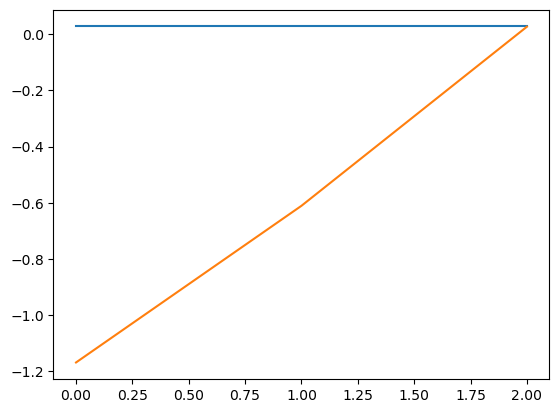

In [87]:
plot_predictions1(model4, X2_test, y2_test)